# Setup

In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm_notebook
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Import Data

In [2]:
impt_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [3]:
impt_data

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,breed_category,pet_category
0,ANSL_69903,2016-07-10 00:00:00,2016-09-21 16:25:00,2.0,Brown Tabby,0.80,7.78,13,9,0.0,1
1,ANSL_66892,2013-11-21 00:00:00,2018-12-27 17:47:00,1.0,White,0.72,14.19,13,9,0.0,2
2,ANSL_69750,2014-09-28 00:00:00,2016-10-19 08:24:00,NaN,Brown,0.15,40.90,15,4,2.0,4
3,ANSL_71623,2016-12-31 00:00:00,2019-01-25 18:30:00,1.0,White,0.62,17.82,0,1,0.0,2
4,ANSL_57969,2017-09-28 00:00:00,2017-11-19 09:38:00,2.0,Black,0.50,11.06,18,4,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
18829,ANSL_51738,2017-01-26 00:00:00,2018-03-09 15:35:00,2.0,Tricolor,0.44,27.36,0,1,0.0,2
18830,ANSL_59900,2016-06-18 00:00:00,2017-07-09 08:37:00,NaN,Brown,0.73,14.25,15,4,2.0,4
18831,ANSL_53210,2010-07-21 00:00:00,2018-08-22 14:27:00,0.0,Calico Point,0.99,28.13,13,9,1.0,1
18832,ANSL_63468,2017-05-12 00:00:00,2018-02-08 14:05:00,0.0,Tan,0.55,44.82,13,9,1.0,2


# Pre Processing

In [4]:
impt_data.fillna(0, inplace = True)

In [5]:
bc_labels_pd = impt_data.pop("breed_category")
pc_labels_pd = impt_data.pop("pet_category")

In [6]:
include_columns = ["condition", "color_type", "length(m)", "height(cm)", "X1", "X2"]
data_pd = impt_data[include_columns]
data_test_pd = test_data[include_columns]

In [7]:
# turn X into dict
data_dict = data_pd.to_dict(orient='records') # turn each row as key-value pairs
data_test_dict = data_test_pd.to_dict(orient='records') # turn each row as key-value pairs

In [8]:
# DictVectorizer
from sklearn.feature_extraction import DictVectorizer
# instantiate a Dictvectorizer object for X
dv_X = DictVectorizer(sparse=False) 
# sparse = False makes the output is not a sparse matrix

# apply dv_X on X_dict
data = dv_X.fit_transform(data_dict)
X_test = dv_X.transform(data_test_dict)
# show X_encoded
X_test

array([[ 0.  ,  7.  ,  0.  , ...,  0.  , 42.73,  0.87],
       [ 0.  ,  1.  ,  0.  , ...,  1.  ,  6.71,  0.06],
       [ 0.  ,  7.  ,  0.  , ...,  1.  , 41.21,  0.24],
       ...,
       [ 0.  ,  7.  ,  0.  , ...,  0.  , 37.19,  0.98],
       [ 0.  ,  2.  ,  0.  , ...,   nan, 23.83,  0.79],
       [ 0.  ,  1.  ,  0.  , ...,  0.  , 24.51,  0.64]])

In [9]:
# # Categorical boolean mask
# categorical_feature_mask = data_pd.dtypes==object

# # filter categorical columns using mask and turn it into a list
# categorical_cols = data_pd.columns[categorical_feature_mask].tolist()

In [10]:
# # instantiate labelencoder object
# le = LabelEncoder()

# # apply le on categorical feature columns
# data_pd[categorical_cols] = data_pd[categorical_cols].apply(lambda col: le.fit_transform(col))
# data_pd[categorical_cols].head(10)

# data_test_pd[categorical_cols] = data_test_pd[categorical_cols].apply(lambda col: le.fit_transform(col))
# data_test_pd[categorical_cols].head(10)

In [11]:
# data = data_pd.to_numpy()
bc_labels = bc_labels_pd.to_numpy()
pc_labels = pc_labels_pd.to_numpy()
labels = np.stack((bc_labels, pc_labels), axis = -1)
# X_test = data_test_pd.to_numpy()
print(data.shape)
print(X_test.shape)
print(labels.shape)

(18834, 61)
(8072, 61)
(18834, 2)


# Train Test Split

In [12]:
X_train, X_val, Y_train, Y_val = train_test_split(data, bc_labels, random_state = 0, test_size = 0.3)

In [13]:
enc = OneHotEncoder()
Y_OH_train = enc.fit_transform(np.expand_dims(Y_train, 1)).toarray()
Y_OH_val = enc.transform(np.expand_dims(Y_val, 1)).toarray()

C:\Users\Sriram Pingali\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [14]:
pc_labels

array([1, 2, 4, ..., 1, 2, 2], dtype=int64)

In [15]:
Y_OH_train[:40]

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [16]:
X_test

array([[ 0.  ,  7.  ,  0.  , ...,  0.  , 42.73,  0.87],
       [ 0.  ,  1.  ,  0.  , ...,  1.  ,  6.71,  0.06],
       [ 0.  ,  7.  ,  0.  , ...,  1.  , 41.21,  0.24],
       ...,
       [ 0.  ,  7.  ,  0.  , ...,  0.  , 37.19,  0.98],
       [ 0.  ,  2.  ,  0.  , ...,   nan, 23.83,  0.79],
       [ 0.  ,  1.  ,  0.  , ...,  0.  , 24.51,  0.64]])

In [17]:
X_train, Y_OH_train, X_val, Y_OH_val, X_test = map(torch.tensor, (X_train, Y_OH_train, X_val, Y_OH_val, X_test))

In [18]:
X_train, X_val, X_test = X_train.float(), X_val.float(), X_test.float()

# Cuda Support

In [19]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'

X_train = X_train.to(device)
X_val = X_val.to(device)
X_test  = X_test.to(device)
Y_OH_train = Y_OH_train.to(device)
Y_OH_val = Y_OH_val.to(device)

In [20]:
Y_OH_train.shape

torch.Size([13183, 3])

# FF Network

In [21]:
class FF_Network(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)
        self.net = nn.Sequential(
            nn.Linear(61, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100,50),
            nn.BatchNorm1d(50),
            nn.ReLU(), 
            nn.Linear(50,16),
            nn.ReLU(),
            nn.Linear(16, 3),
        )
           
    def forward(self, X):
        return(self.net(X))

In [22]:
ff_n = FF_Network()
ff_n = ff_n.to(device)
loss_fn = nn.CrossEntropyLoss()

In [23]:
def accuracy(Y_hat, Y):
    accuracy = accuracy_score(np.argmax(Y_hat.cpu().detach().numpy(), 1), np.argmax(Y.cpu().detach().numpy(), 1))
    f1_scr = f1_score(np.argmax(Y_hat.cpu().detach().numpy(), 1), np.argmax(Y.cpu().detach().numpy(), 1), average='macro')
    kappa = cohen_kappa_score(np.argmax(Y_hat.cpu().detach().numpy(), 1), np.argmax(Y.cpu().detach().numpy(), 1))
    return(accuracy, f1_scr, kappa)

In [24]:
def train(X, Y, model, loss_fn = loss_fn, lr = 0.02, epochs = 2500, batch_size = 512):
    loss_b = []
    acc_b = []
    acc = 0
    optm = optim.Adam(ff_n.parameters(), lr = lr)
    Y_temp = Y.to('cpu')
    Y = np.argmax(Y_temp, 1)
    Y = Y.to(device)
    for i in tqdm_notebook(range(epochs)):
        for i in range(X.shape[0] // batch_size):
            local_X, local_Y, local_y_temp = X[i*batch_size:(i+1)*batch_size,], Y[i*batch_size:(i+1)*batch_size,], Y_temp[i*batch_size:(i+1)*batch_size,]
            Y_hat = model.forward(local_X)
            loss = loss_fn(Y_hat, local_Y)
            acc, _, _ = accuracy(Y_hat, local_y_temp)
            loss_b.append(loss.item())
            acc_b.append(acc)
            loss.backward()
            optm.step()
            optm.zero_grad()
    return(loss_b, acc_b, acc)

In [40]:
%%time
loss_b, acc_b, acc_score = train(X_train, Y_OH_train, ff_n, loss_fn, lr = 0.008, epochs = 1000, batch_size = 8192)


Wall time: 2min 8s


Text(0, 0.5, 'acc')

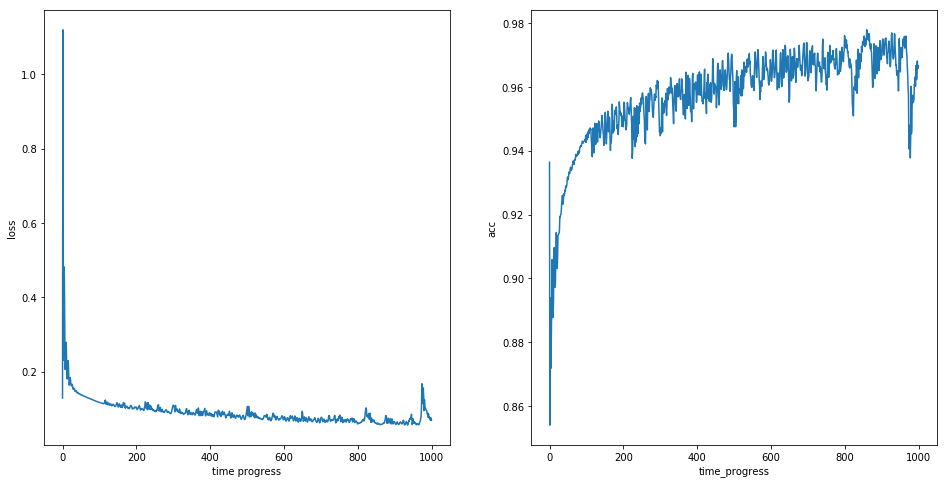

In [41]:
fig = plt.figure(figsize = (16, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(loss_b)
ax1.set_xlabel('time progress')
ax1.set_ylabel('loss')
ax2.plot(acc_b)
ax2.set_xlabel('time_progress')
ax2.set_ylabel('acc')

In [42]:
acc_b

[0.9364013671875,
 0.85400390625,
 0.8809814453125,
 0.8939208984375,
 0.871826171875,
 0.8814697265625,
 0.8922119140625,
 0.9058837890625,
 0.9002685546875,
 0.8876953125,
 0.888671875,
 0.8944091796875,
 0.908203125,
 0.90966796875,
 0.9012451171875,
 0.897216796875,
 0.898193359375,
 0.907470703125,
 0.914306640625,
 0.9132080078125,
 0.905029296875,
 0.903076171875,
 0.907470703125,
 0.9134521484375,
 0.91357421875,
 0.9140625,
 0.9141845703125,
 0.915283203125,
 0.9193115234375,
 0.919189453125,
 0.919921875,
 0.9200439453125,
 0.92138671875,
 0.923828125,
 0.92431640625,
 0.926025390625,
 0.9232177734375,
 0.923828125,
 0.925048828125,
 0.926513671875,
 0.926025390625,
 0.9266357421875,
 0.9276123046875,
 0.927490234375,
 0.928955078125,
 0.928466796875,
 0.9288330078125,
 0.9293212890625,
 0.9310302734375,
 0.9317626953125,
 0.930908203125,
 0.9312744140625,
 0.9324951171875,
 0.933349609375,
 0.9329833984375,
 0.932861328125,
 0.9342041015625,
 0.934814453125,
 0.9344482421875

In [43]:
# ff_n.eval()
print("Train set accuracy, f1 score, kappa: ", accuracy(ff_n.forward(X_train), Y_OH_train), "\nValidation set accuracy, f1 score: ", accuracy(ff_n.forward(X_val), Y_OH_val))#, "\nTest set accuracy, f1 score: ", accuracy(ff_n.forward(X_test), Y_OH_test))

Train set accuracy, f1 score, kappa:  (0.9208071000530987, 0.9006936820219386, 0.8615042569292717) 
Validation set accuracy, f1 score:  (0.8437444700053088, 0.8041278892988886, 0.726879717469232)


# Visual Evaluation

[[2291  360    1]
 [ 244 2153  149]
 [   0  129  324]]


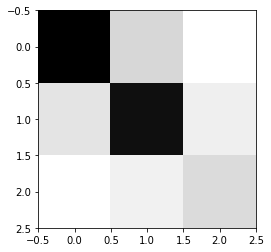

In [44]:
cm = confusion_matrix(np.argmax(Y_OH_val.to('cpu').detach().numpy(), 1), np.argmax(ff_n(X_val).to('cpu').detach().numpy(), 1))
print(cm)
plt.imshow(cm, cmap='binary')

[[5898  450    0]
 [ 265 5319  227]
 [   1  101  922]]


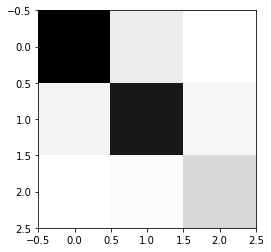

In [45]:
cm = confusion_matrix(np.argmax(Y_OH_train.to('cpu').detach().numpy(), 1), np.argmax(ff_n(X_train).to('cpu').detach().numpy(), 1))
print(cm)
plt.imshow(cm, cmap='binary')

# Saving Model

In [46]:
torch.save(ff_n.state_dict(), './weights')

In [47]:
model = FF_Network()
model.load_state_dict(torch.load('./weights'))
model.eval()
model.to(device)

FF_Network(
  (net): Sequential(
    (0): Linear(in_features=61, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=50, bias=True)
    (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=16, bias=True)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=3, bias=True)
  )
)

In [48]:
Y_test_pred = model.forward(X_test)

In [49]:
print("Train set Accuracy, F1 score, Cohen's Kappa: ", accuracy(model.forward(X_train), Y_OH_train), "\nValidation set Accuracy, F1 score, Cohens Kappa: ", accuracy(model.forward(X_val), Y_OH_val))

Train set Accuracy, F1 score, Cohen's Kappa:  (0.913145717970113, 0.894453470724069, 0.8482770059317426) 
Validation set Accuracy, F1 score, Cohens Kappa:  (0.8425057511944789, 0.8050389476582706, 0.7253271692842485)


In [50]:
import csv

with open('submission.csv', 'w', newline='') as file:
    with open('test.csv', 'r') as inp:
        writer = csv.writer(file)
        reader = csv.reader(inp)
        heading = next(reader)
        heading.append("class")
        writer.writerow(['class'])
        for i, row in enumerate(reader):
            writer.writerow([np.argmax(Y_test_pred.to('cpu').detach().numpy(), 1)[i]])